# Most probably path predictions

### Introduction

The ability to drive conversion between different cell states has garnered a great deal of attention as a promising avenue for disease modeling (Graf and Enver, 2009). A fundamental challenge in the field of stem cell biology is thus to assess the feasibility and identify optimal paths and key TFs (transcription factors) of such interconversions (Figure 6A) (Graf and Enver, 2009; Zhou and Huang, 2011).  The least action path (`least_action`: a functional of the trajectory) is a principled method  that has previously been used in theoretical efforts to predict the most probable path a cell will follow during fate transition (Qiu et al., 2012; Wang et al., 2011, 2014). Specifically, the optimal path between any two cell states (e.g. the fixed point of HSCs and that of megakaryocytes) is searched by variating the continuous path connecting the source state to the target while minimizing its action and updating the associated transition time. The resultant least action path has the highest transition probability and is associated with a particular transition time.  
In this tutorial, we will showcase 
- how to perform LAP
- visualize transition paths found by LAP on vectorfield
- heatmaps of pairwise actions and transition times; transcriptomics factor ranking; RoC curve of priority scores

Import relevant packages

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot
import matplotlib.pyplot as plt

# import Scribe as sb
import sys
import os

# import scanpy as sc
import dynamo as dyn

dyn.dynamo_logger.main_silence()


In [20]:
# adata_labeling = dyn.read_h5ad("./data/hematopoietic_processed_v1.h5ad") 
adata_labeling = dyn.sample_data.hematopoiesis()


In [21]:
adata_labeling

AnnData object with n_obs × n_vars = 1947 × 1956
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curv_leiden', 'curv_louvain', 'SPI1->GATA1_jacobian', 'jacobian', 'umap_ori_leiden', 'umap_ori_louvain', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'acceleration_umap', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'curvature_umap_ori'
    var: 'gene_name', 'gene_id', 'nCells', 'nCounts', 'pass_basic

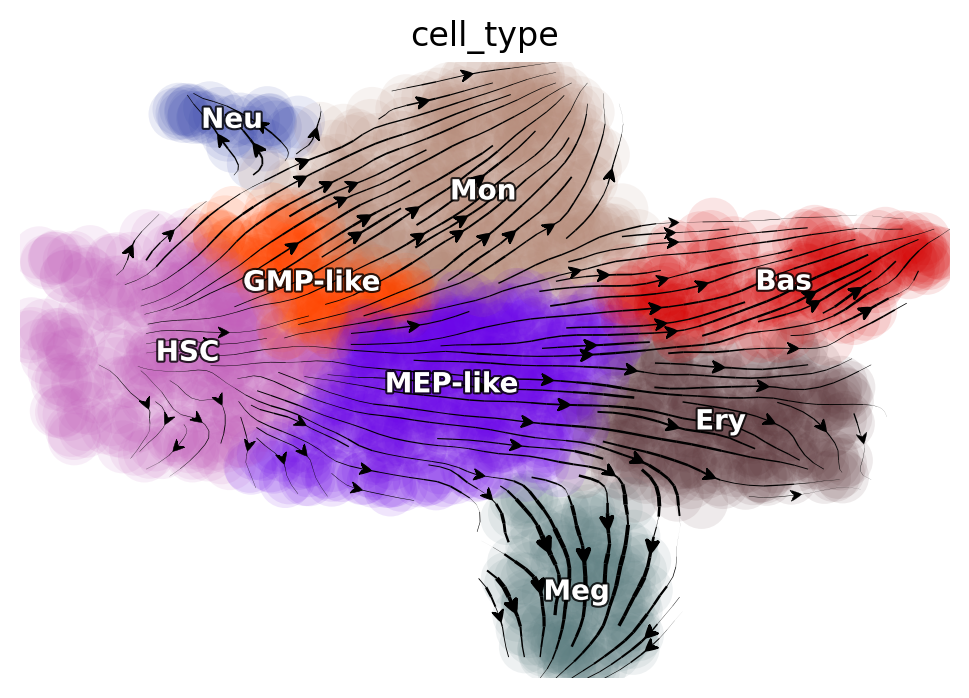

In [22]:
HSC_cells = dyn.tl.select_cell(adata_labeling, "cell_type", "HSC")
Meg_cells = dyn.tl.select_cell(adata_labeling, "cell_type", "Meg")
Ery_cells = dyn.tl.select_cell(adata_labeling, "cell_type", "Ery")
Bas_cells = dyn.tl.select_cell(adata_labeling, "cell_type", "Bas")
Mon_cells = dyn.tl.select_cell(adata_labeling, "cell_type", "Mon")
Neu_cells = dyn.tl.select_cell(adata_labeling, "cell_type", "Neu")

dyn.pl.streamline_plot(adata_labeling, basis="umap", color="cell_type")


Select the most extreme cells from alpha and beta cells as the starting and end points. 
The most extreme cells are selected manually based on UMAP visualization above and their coordinates are stored in `extreme_points`.  
Then neighbors of these `extreme_points` are saved to `*_cells_indices variables`, which stores indices of these points in adata.

In [23]:
from dynamo.tools.utils import nearest_neighbors

extreme_points = np.array(
    [
        [8.45201833, 9.37697661],
        [14.00630381, 2.53853712],
        [17.30550636, 6.81561775],
        [18.06891717, 11.9840678],
        [14.13613403, 15.22244713],
        [9.72644402, 14.83745969],
    ]
)

HSC_cells_indices = nearest_neighbors(extreme_points[0], adata_labeling.obsm["X_umap"])
Meg_cells_indices = nearest_neighbors(extreme_points[1], adata_labeling.obsm["X_umap"])
Ery_cells_indices = nearest_neighbors(extreme_points[2], adata_labeling.obsm["X_umap"])
Bas_cells_indices = nearest_neighbors(extreme_points[3], adata_labeling.obsm["X_umap"])
Mon_cells_indices = nearest_neighbors(extreme_points[4], adata_labeling.obsm["X_umap"])
Neu_cells_indices = nearest_neighbors(extreme_points[5], adata_labeling.obsm["X_umap"])


/Users/random/opt/anaconda3/envs/dynamo-dev/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


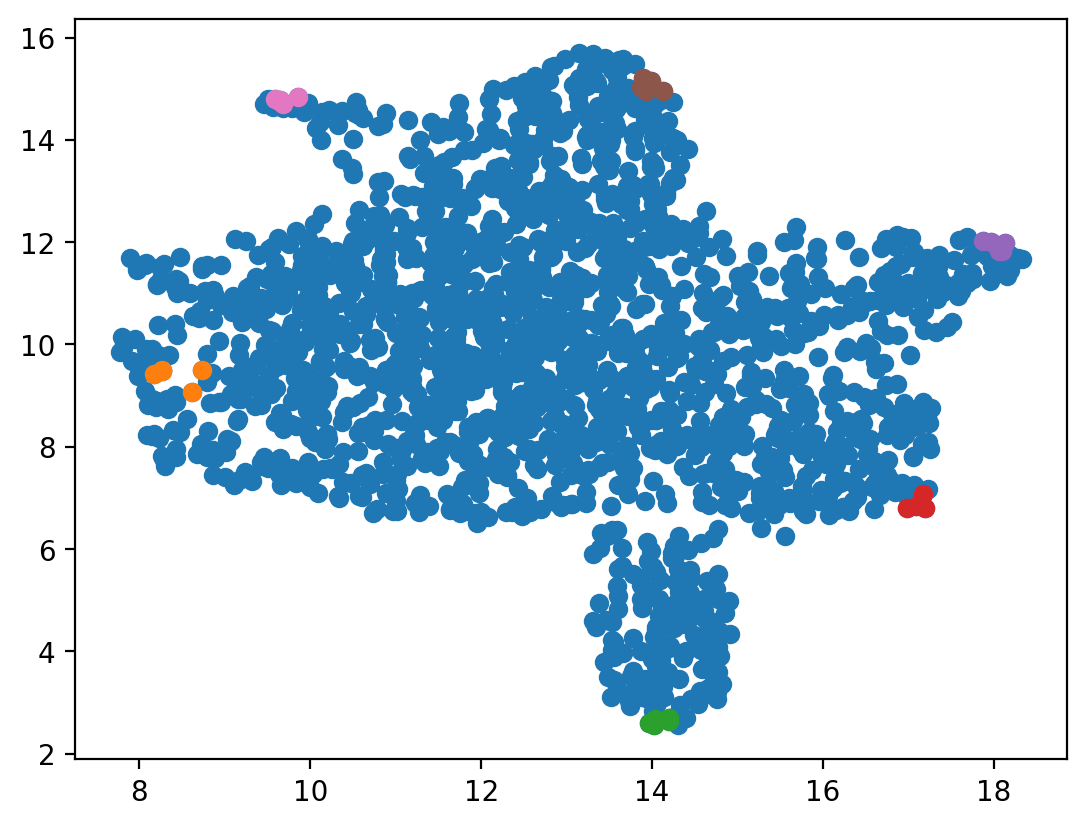

In [24]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(4, 4))

plt.scatter(*adata_labeling.obsm["X_umap"].T)
for indices in [
    HSC_cells_indices,
    Meg_cells_indices,
    Ery_cells_indices,
    Bas_cells_indices,
    Mon_cells_indices,
    Neu_cells_indices,
]:
    plt.scatter(*adata_labeling[indices[0]].obsm["X_umap"].T)


In [25]:
HSC_cells_indices


array([[1587, 1557, 1725, 1091, 1070]])

## Development  path for Meg, Ery, Bas, Mon and Neu cells 

### Compute neighbor graph based on `umap`

In [26]:
dyn.tl.neighbors(adata_labeling, basis="umap", result_prefix="umap")


|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:umap
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> <insert> umap_connectivities to obsp in AnnData Object.
|-----> <insert> umap_distances to obsp in AnnData Object.
|-----> <insert> umap_neighbors to uns in AnnData Object.
|-----> <insert> umap_neighbors.indices to uns in AnnData Object.
|-----> <insert> umap_neighbors.params to uns in AnnData Object.


AnnData object with n_obs × n_vars = 1947 × 1956
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curv_leiden', 'curv_louvain', 'SPI1->GATA1_jacobian', 'jacobian', 'umap_ori_leiden', 'umap_ori_louvain', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'acceleration_umap', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'curvature_umap_ori'
    var: 'gene_name', 'gene_id', 'nCells', 'nCounts', 'pass_basic

### Run pairwise least action path among cell states

Compute LAP for all cell type transition pairs. The main interface in dynamo is `dyn.pd.least_action`. This function takes `adata`, start cell type and end cell type to compute least action path. As shown below, different basis can be used. Here we use PCA basis to compute LAP for downstream analysis.
Please refer to specific API documentation for detailed parameter explanation.

In [27]:
%%capture

dyn.dynamo_logger.main_silence()
transition_graph = {}
cell_type = ["HSC", "Meg", "Ery", "Bas", "Mon", "Neu"]
start_cell_indices = [
    HSC_cells_indices,
    Meg_cells_indices,
    Ery_cells_indices,
    Bas_cells_indices,
    Mon_cells_indices,
    Neu_cells_indices,
]
end_cell_indices = start_cell_indices
for i, start in enumerate(start_cell_indices):
    for j, end in enumerate(end_cell_indices):
        if start is not end:
            min_lap_t = True if i == 0 else False
            dyn.pd.least_action(
                adata_labeling,
                [adata_labeling.obs_names[start[0]][0]],
                [adata_labeling.obs_names[end[0]][0]],
                basis="umap",
                adj_key="X_umap_distances",
                min_lap_t= min_lap_t,
                EM_steps=2,
            )
            dyn.pl.least_action(adata_labeling, basis="umap")
            lap = dyn.pd.least_action(
                adata_labeling,
                [adata_labeling.obs_names[start[0]][0]],
                [adata_labeling.obs_names[end[0]][0]],
                basis="pca",
                adj_key="cosine_transition_matrix",
                min_lap_t=min_lap_t,
                EM_steps=2,
            )
            dyn.pl.kinetic_heatmap(
                adata_labeling,
                basis="pca",
                mode="lap",
                genes=adata_labeling.var_names[adata_labeling.var.use_for_transition],
                project_back_to_high_dim=True,
            )
            # The `GeneTrajectory` class can be used to output trajectories for any set of genes of interest
            gtraj = dyn.pd.GeneTrajectory(adata_labeling)
            gtraj.from_pca(lap.X, t=lap.t)
            gtraj.calc_msd()
            ranking = dyn.vf.rank_genes(adata_labeling, "traj_msd")

            print(start, "->", end)
            genes = ranking[:5]["all"].to_list()
            arr = gtraj.select_gene(genes)

            dyn.pl.multiplot(lambda k: [plt.plot(arr[k, :]), plt.title(genes[k])], np.arange(len(genes)))

            transition_graph[cell_type[i] + "->" + cell_type[j]] = {
                "lap": lap,
                "LAP_umap": adata_labeling.uns["LAP_umap"],
                "LAP_pca": adata_labeling.uns["LAP_pca"],
                "ranking": ranking,
                "gtraj": gtraj,
            }


|-----> [iterating through 1 pairs] in progress: 100.0000%
|-----> [iterating through 1 pairs] finished [4.7995s]
|-----> [iterating through 1 pairs] in progress: 100.0000%
|-----> [iterating through 1 pairs] finished [86.5040s]
|-----> [iterating through 1 pairs] in progress: 100.0000%
|-----> [iterating through 1 pairs] finished [6.0449s]
|-----> [iterating through 1 pairs] in progress: 100.0000%
|-----> [iterating through 1 pairs] finished [88.2639s]
|-----> [iterating through 1 pairs] in progress: 100.0000%
|-----> [iterating through 1 pairs] finished [6.2688s]
|-----> [iterating through 1 pairs] in progress: 100.0000%
|-----> [iterating through 1 pairs] finished [86.5914s]
|-----> [iterating through 1 pairs] in progress: 100.0000%
|-----> [iterating through 1 pairs] finished [6.3474s]
|-----> [iterating through 1 pairs] in progress: 100.0000%
|-----> [iterating through 1 pairs] finished [91.4315s]
|-----> [iterating through 1 pairs] in progress: 100.0000%
|-----> [iterating throug

## Developmental LAPs

In [28]:
develope_keys = ["HSC->Meg", "HSC->Ery", "HSC->Bas", "HSC->Mon", "HSC->Neu"]
reprogram_keys = ["Meg->HSC", "Ery->HSC", "Bas->HSC", "Mon->HSC", "Neu->HSC"]
transdifferentiation = [
    "Ery->Meg",
    "Neu->Bas",
    "Mon->Ery",
    "Bas->Meg",
    "Neu->Meg",
    "Meg->Bas",
    "Mon->Bas",
    "Neu->Mon",
    "Meg->Ery",
    "Ery->Bas",
    "Bas->Mon",
    "Mon->Neu",
    "Neu->Ery",
    "Mon->Meg",
    "Bas->Neu",
    "Meg->Neu",
    "Ery->Mon",
    "Meg->Mon",
    "Ery->Neu",
    "Bas->Ery",
]


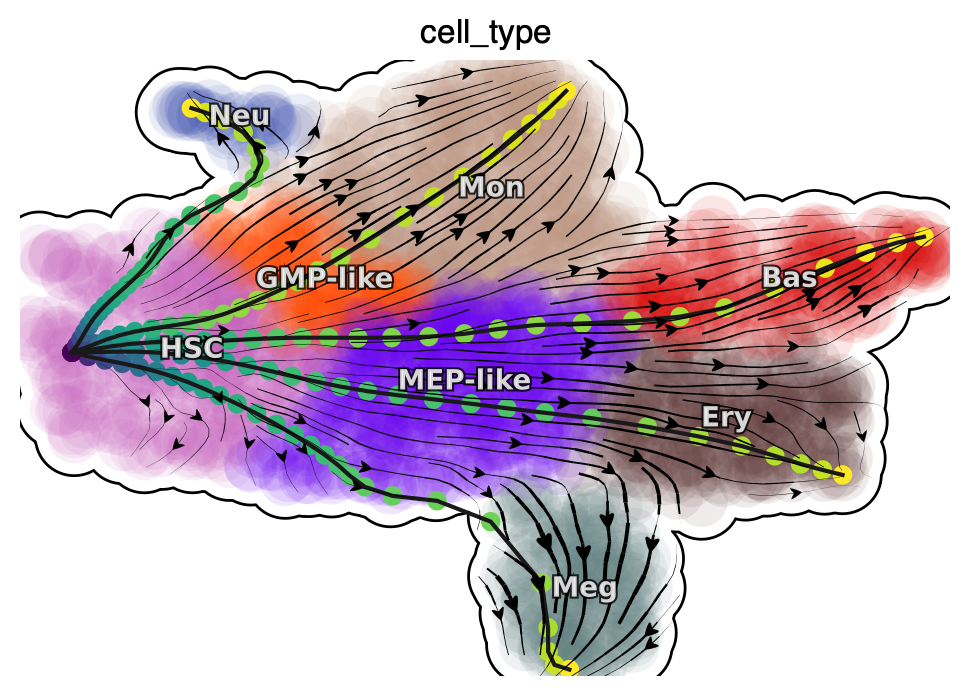

In [56]:
from dynamo.plot.utils import map2color
def plot_lap(paths):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax = dyn.pl.streamline_plot(
        adata_labeling, basis="umap", save_show_or_return="return", ax=ax, color="cell_type", frontier=True
    )
    ax = ax[0]
    x, y = 0, 1

    # plot paths
    for path in paths:
        lap_dict = transition_graph[path]["LAP_umap"]
        for prediction, action in zip(lap_dict["prediction"], lap_dict["action"]):
            ax.scatter(*prediction[:, [x, y]].T, c=map2color(action))
            ax.plot(*prediction[:, [x, y]].T, c="k")
plot_lap(develope_keys)



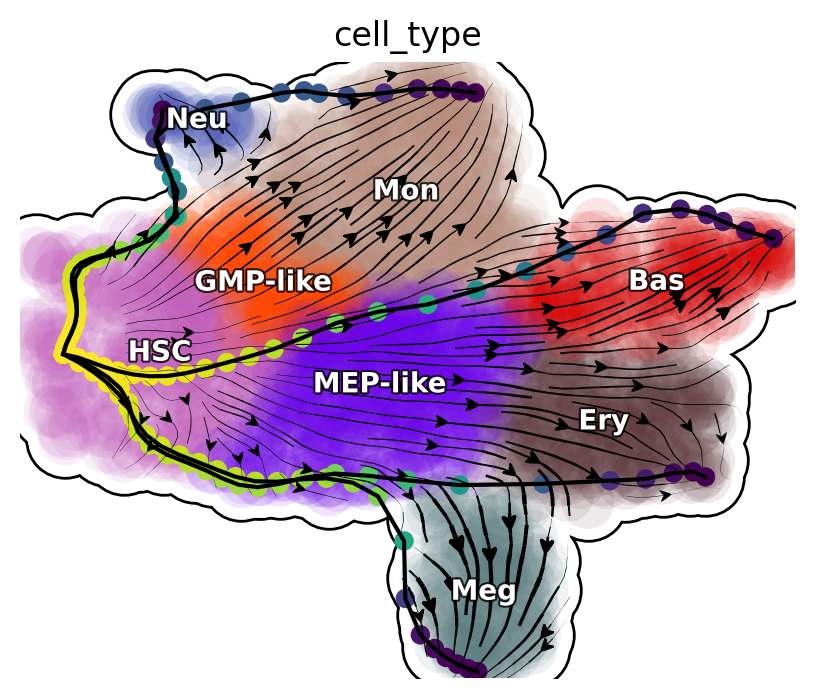

In [41]:
plot_lap(reprogram_keys)


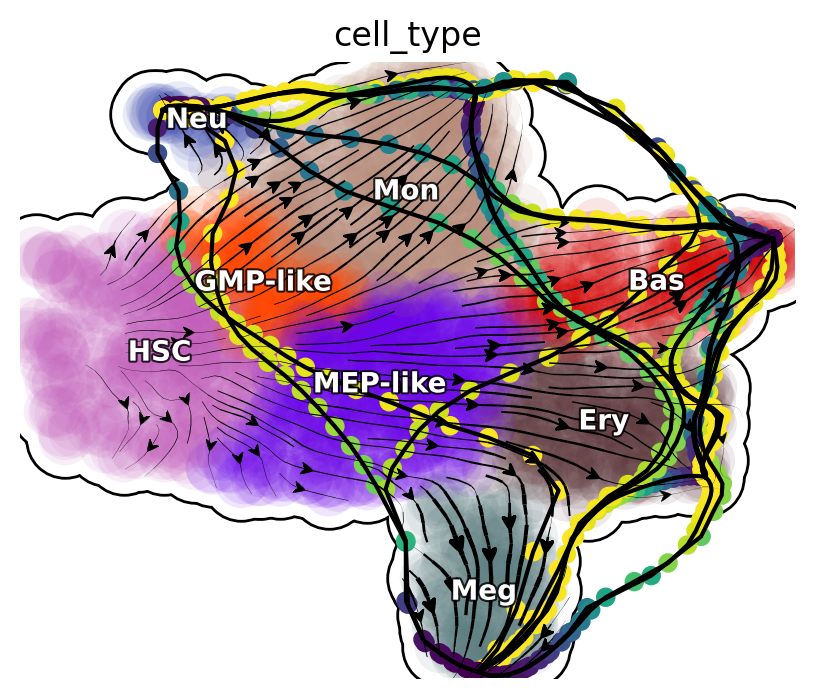

In [42]:

plot_lap(transdifferentiation)


In [44]:
human_tfs = dyn.sample_data.human_tfs()
human_tfs_names = list(human_tfs["Symbol"])


In [45]:
action_df = pd.DataFrame(index=cell_type, columns=cell_type)
t_df = pd.DataFrame(index=cell_type, columns=cell_type)
for i, start in enumerate(
    [
        HSC_cells_indices,
        Meg_cells_indices,
        Ery_cells_indices,
        Bas_cells_indices,
        Mon_cells_indices,
        Neu_cells_indices,
    ]
):
    for j, end in enumerate(
        [
            HSC_cells_indices,
            Meg_cells_indices,
            Ery_cells_indices,
            Bas_cells_indices,
            Mon_cells_indices,
            Neu_cells_indices,
        ]
    ):
        if start is not end:
            print(cell_type[i] + "->" + cell_type[j], end=",")
            lap = transition_graph[cell_type[i] + "->" + cell_type[j]]["lap"]  # lap
            gtraj = transition_graph[cell_type[i] + "->" + cell_type[j]]["gtraj"]
            ranking = transition_graph[cell_type[i] + "->" + cell_type[j]]["ranking"].copy()
            ranking["TF"] = [i in human_tfs_names for i in list(ranking["all"])]
            genes = ranking.query("TF == True").head(10)["all"].to_list()
            arr = gtraj.select_gene(genes)
            action_df.loc[cell_type[i], cell_type[j]] = lap.action()[-1]
            t_df.loc[cell_type[i], cell_type[j]] = lap.t[-1]


HSC->Meg,HSC->Ery,HSC->Bas,HSC->Mon,HSC->Neu,Meg->HSC,Meg->Ery,Meg->Bas,Meg->Mon,Meg->Neu,Ery->HSC,Ery->Meg,Ery->Bas,Ery->Mon,Ery->Neu,Bas->HSC,Bas->Meg,Bas->Ery,Bas->Mon,Bas->Neu,Mon->HSC,Mon->Meg,Mon->Ery,Mon->Bas,Mon->Neu,Neu->HSC,Neu->Meg,Neu->Ery,Neu->Bas,Neu->Mon,

    integration time lineage
HSC              NaN     HSC
Meg        28.335868     Meg
Ery        46.227644     Ery
Bas        45.575254     Bas
Mon        41.797433     Mon
Neu        76.469544     Neu


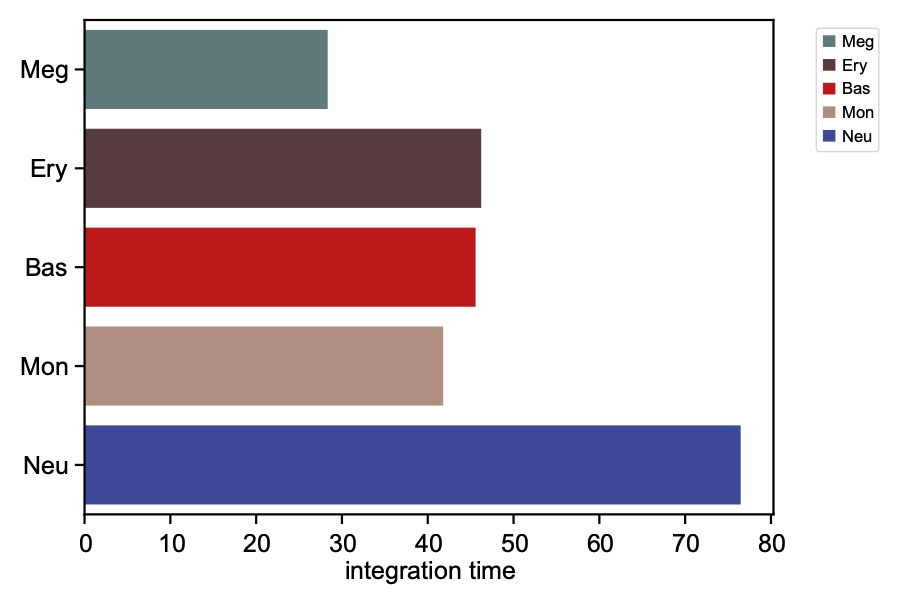

In [46]:
dyn.configuration.set_pub_style(scaler=1.5)
develop_time_df = pd.DataFrame({"integration time": t_df.iloc[0, :].T})
develop_time_df["lineage"] = ["HSC", "Meg", "Ery", "Bas", "Mon", "Neu"]
print(develop_time_df)
ig, ax = plt.subplots(figsize=(4, 3))
dynamo_color_dict = {
    "Mon": "#b88c7a",
    "Meg": "#5b7d80",
    "MEP-like": "#6c05e8",
    "Ery": "#5d373b",
    "Bas": "#d70000",
    "GMP-like": "#ff4600",
    "HSC": "#c35dbb",
    "Neu": "#2f3ea8",
}

sns.barplot(
    y="lineage",
    x="integration time",
    hue="lineage",
    data=develop_time_df.iloc[1:, :],
    dodge=False,
    palette=dynamo_color_dict,
    ax=ax,
)
ax.set_ylabel("")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")


## Heatmap of pairwise celltype actions and time of transitions


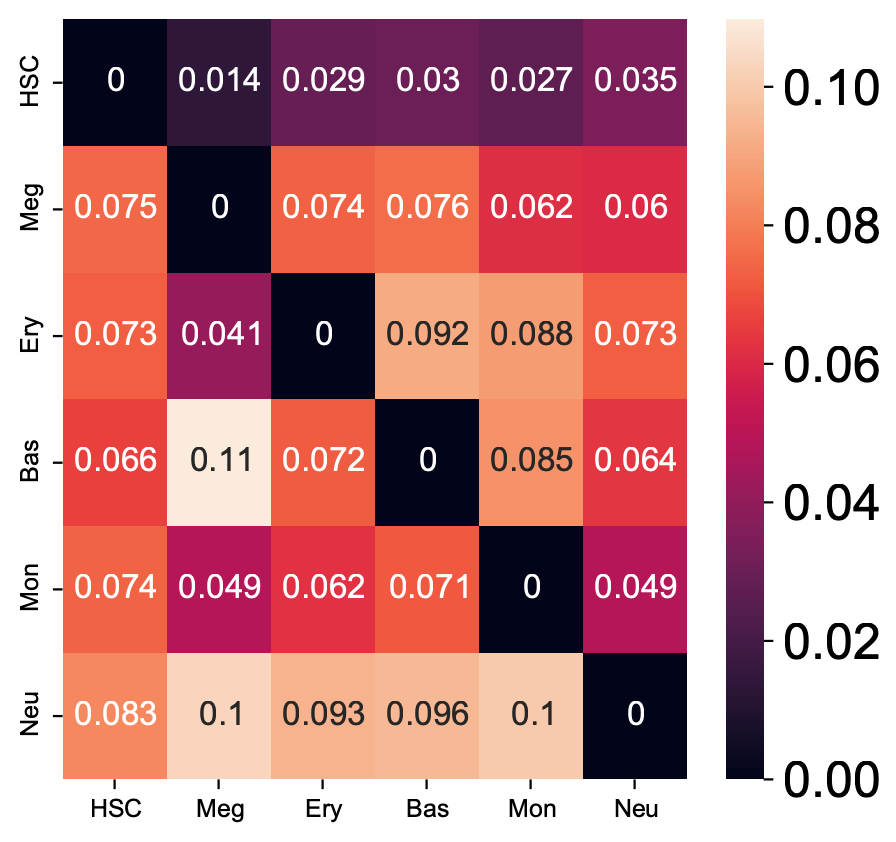

In [47]:
action_df = action_df.fillna(0)
f, ax = plt.subplots(figsize=(5, 5))
dyn.configuration.set_pub_style(scaler=3)
ax = sns.heatmap(action_df, annot=True, ax=ax, fmt=".2g")


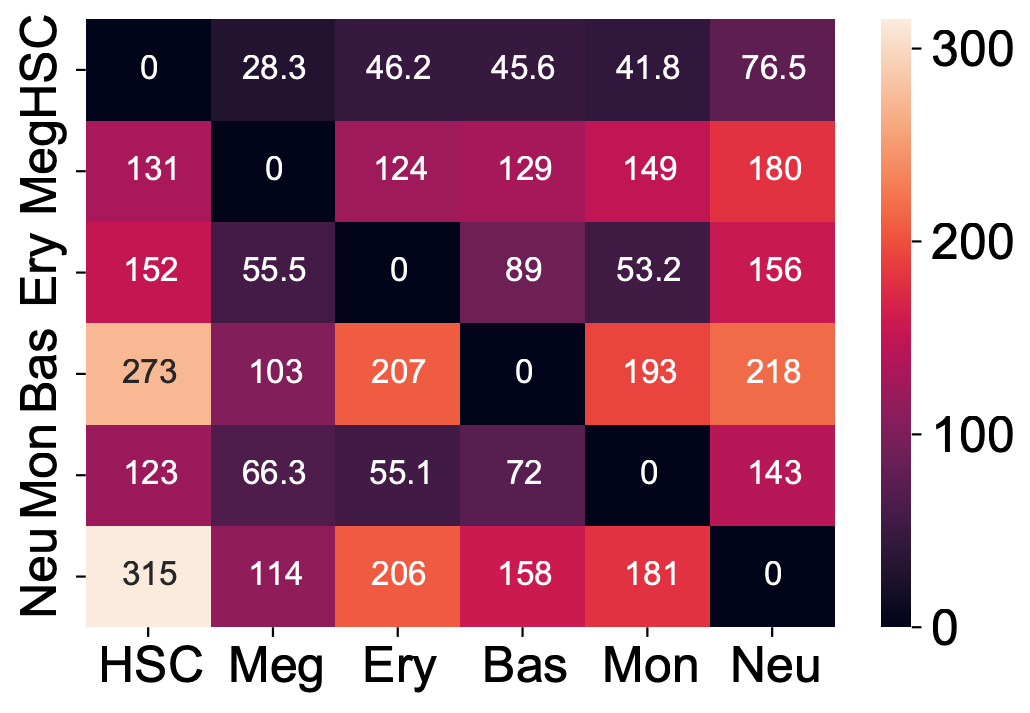

In [48]:
t_df = t_df.fillna(0)
dyn.configuration.set_pub_style(scaler=3)
ax = sns.heatmap(t_df, annot=True, fmt=".3g")


## Kinetics Heatmap via LAP  

In this section we will show how to generate kinetics heatmap based on LAP. Dynamo provides you with `dyn.pd.least_action`, a function computing the optimal paths between any two cell states in selected basis. Then `dyn.pl.kinetic_heatmap` can be used to plot kinetics heatmap.  

First we assign observation names to `init_cells` and `target_cells`. Note that for demonstration and paper figure reproduction, we only store 1 cell instance in init and end cell list. You may use multiple cells as inputs of `dyn.pd.least_action`.

In [49]:
init_cells = [adata_labeling.obs_names[HSC_cells_indices[0][0]]]
target_cells = [adata_labeling.obs_names[Bas_cells_indices[0][0]]]
print("init cells:", init_cells)
print("target cells:", target_cells)

init cells: ['GGGGGGCGGCCT-JL_10']
target cells: ['GCAGCGAAGGCA-JL12_0']


Compute via `least_action` interface. More information regarding this function can be found in API documentation.

In [50]:
dyn.configuration.set_pub_style(scaler=0.6)

lap = dyn.pd.least_action(
    adata_labeling,
    init_cells=init_cells,
    target_cells=target_cells,
    basis="pca",
    adj_key="cosine_transition_matrix",
)


|-----> [iterating through 1 pairs] in progress: 100.0000%

/Users/random/opt/anaconda3/envs/dynamo-dev/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


|-----> [iterating through 1 pairs] in progress: 100.0000%
|-----> [iterating through 1 pairs] finished [10.6649s]


Visualize computed LAP information via `dyn.pl.kinetic_heatmap`. Note x-axis below represents cell type transition path time, LAP time. In this case it is `HSC->Bas`. Y-axis is self-explanatory, representing gene names.

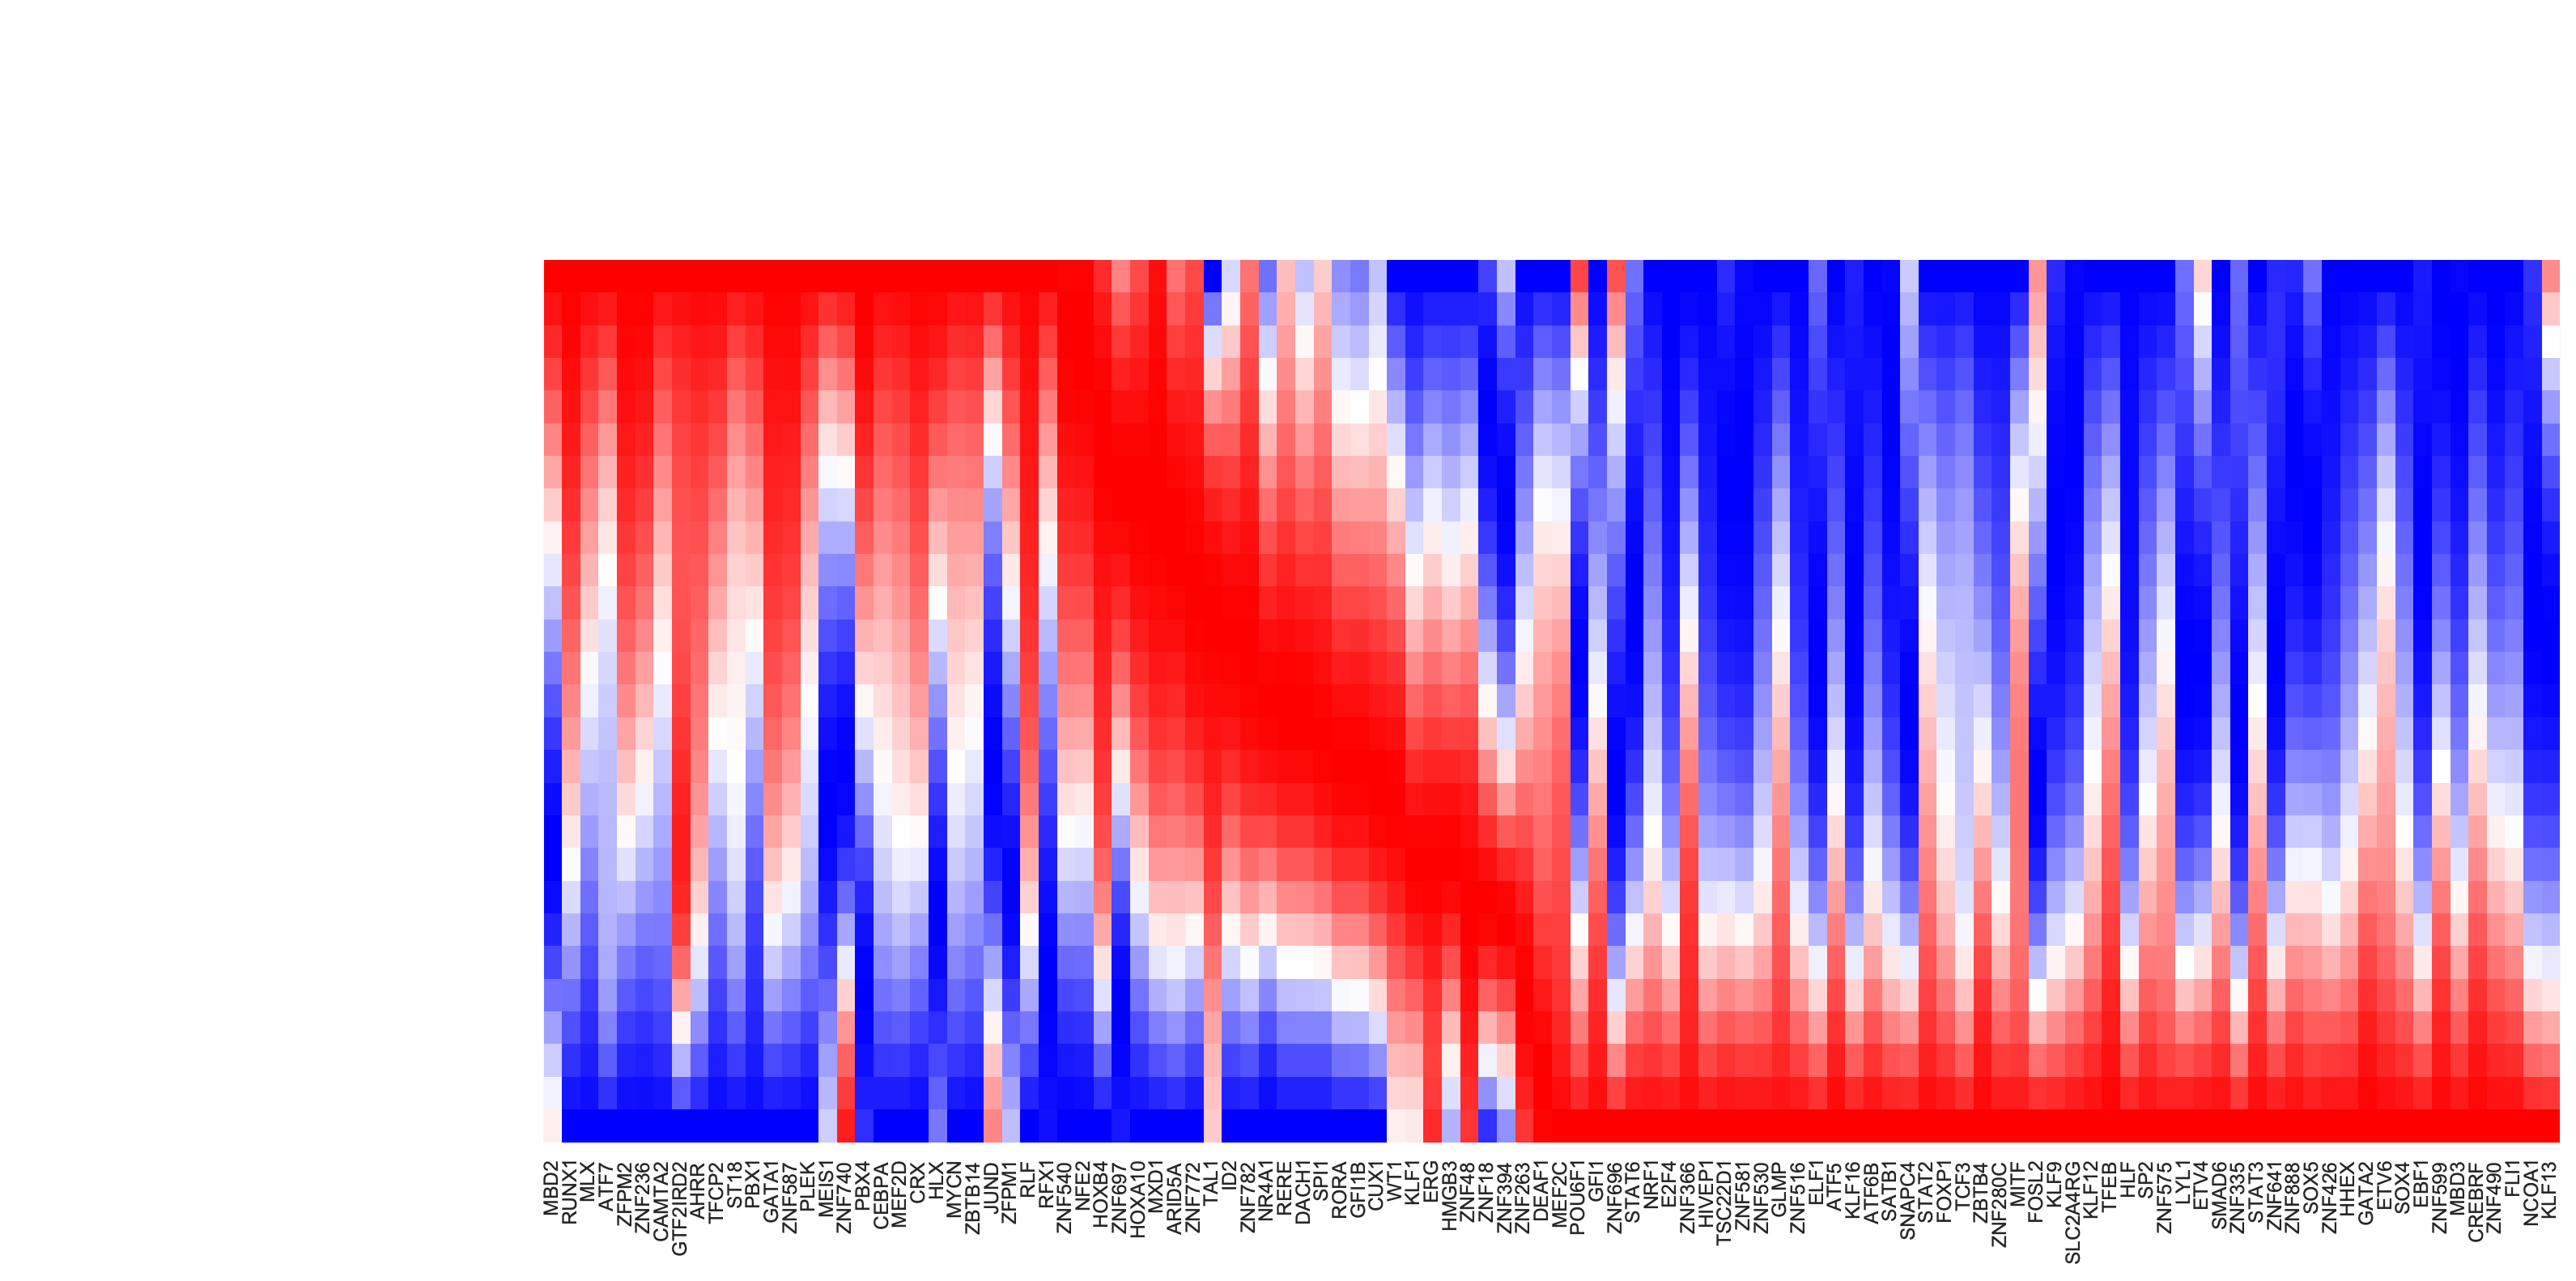

In [51]:
from matplotlib import pyplot, transforms

is_human_tfs = [gene in human_tfs_names for gene in adata_labeling.var_names[adata_labeling.var.use_for_transition]]
human_genes = adata_labeling.var_names[adata_labeling.var.use_for_transition][is_human_tfs]
dyn.configuration.set_pub_style(scaler=0.6)

sns.set(font_scale=0.8)
sns_heatmap = dyn.pl.kinetic_heatmap(
    adata_labeling,
    basis="pca",
    mode="lap",
    figsize=(16, 8),
    genes=human_genes,
    project_back_to_high_dim=True,
    save_show_or_return="return",
    color_map="bwr",
    transpose=True,
    xticklabels=True,
    yticklabels=False,
)
plt.setp(sns_heatmap.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.tight_layout()


|-----> [iterating through 1 pairs] in progress: 100.0000%

/Users/random/opt/anaconda3/envs/dynamo-dev/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


|-----> [iterating through 1 pairs] in progress: 100.0000%
|-----> [iterating through 1 pairs] finished [28.9093s]


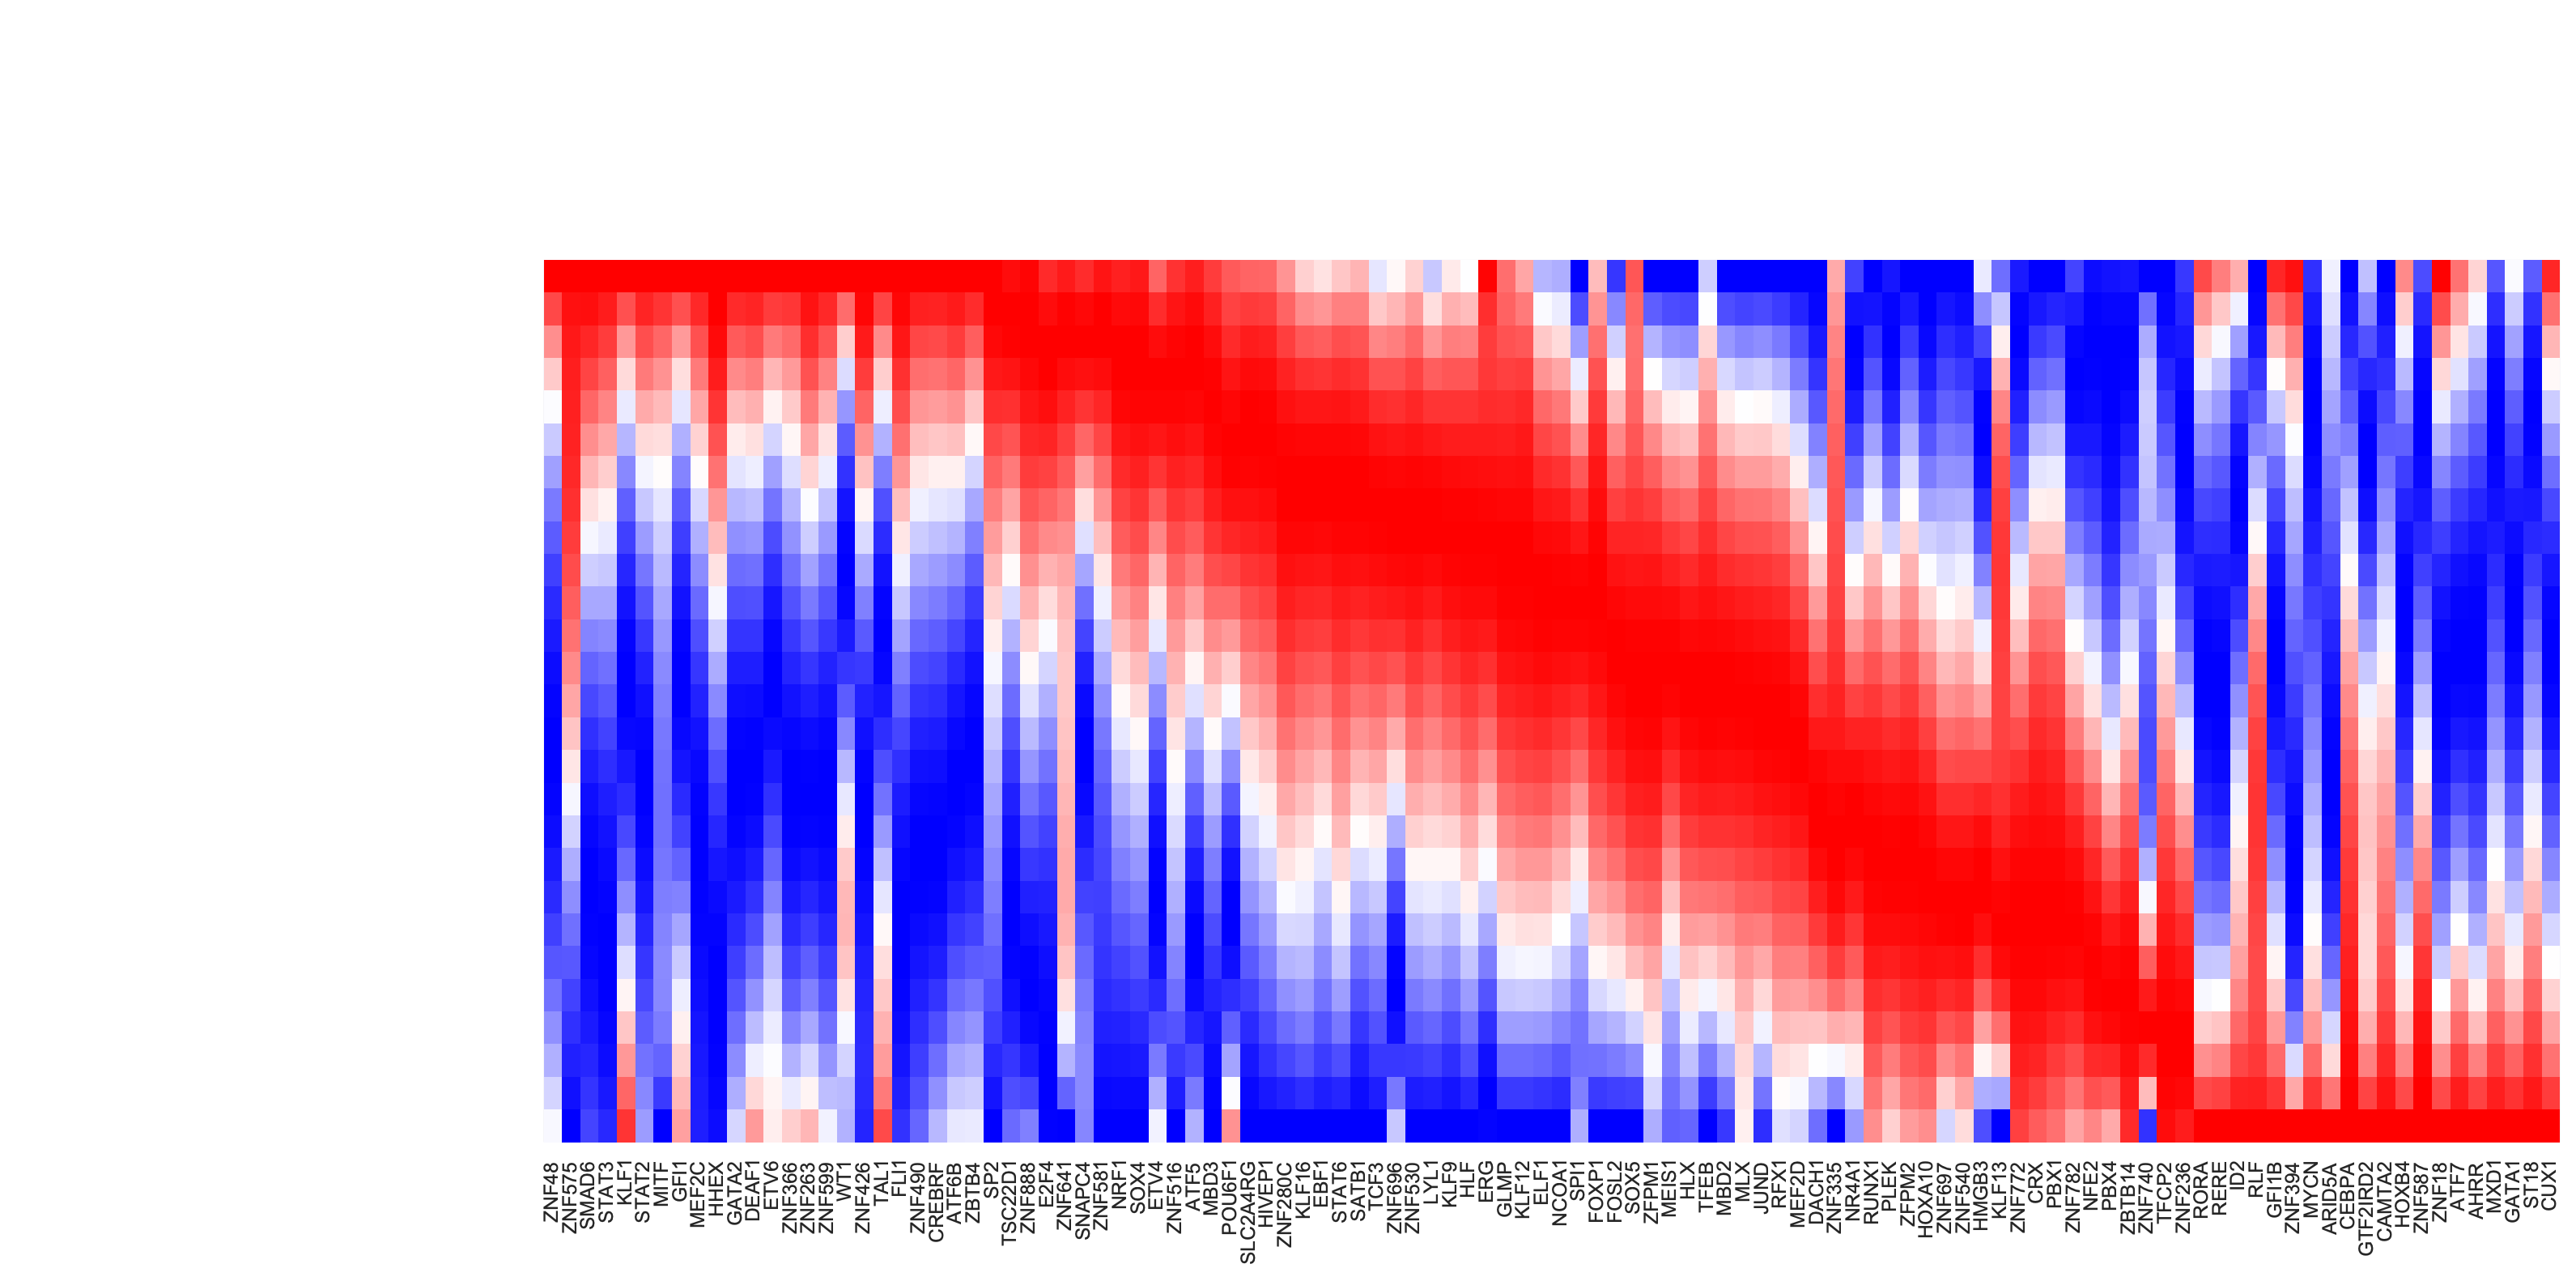

In [53]:
from matplotlib import pyplot, transforms

is_human_tfs = [gene in human_tfs_names for gene in adata_labeling.var_names[adata_labeling.var.use_for_transition]]
human_genes = adata_labeling.var_names[adata_labeling.var.use_for_transition][is_human_tfs]
lap = dyn.pd.least_action(
    adata_labeling,
    init_cells=target_cells,
    target_cells=init_cells,
    basis="pca",
    adj_key="cosine_transition_matrix",
)
sns.set(font_scale=0.8)
sns_heatmap = dyn.pl.kinetic_heatmap(
    adata_labeling,
    basis="pca",
    mode="lap",
    figsize=(16, 8),
    genes=human_genes,
    project_back_to_high_dim=True,
    save_show_or_return="return",
    color_map="bwr",
    transpose=True,
    xticklabels=True,
    yticklabels=False,
)
plt.setp(sns_heatmap.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.tight_layout()


## Rank transcriptomics factors (TFs)
Here we will show how to leverage information we processed and stored in `transition_graph` to produce visualization results of ranking of TFs in transition paths.  

### Assign TF rankings based on literature review  

We first prepare ranking dataframes used to plot ranking info in this section. This part is specific to your dataset and little dynamo specific API is involved, so you may skip this part in your own cases.

In [57]:
%%capture
HSC_Meg_ranking = transition_graph["HSC->Meg"]["ranking"]
HSC_Meg_ranking["TF"] = [i in human_tfs_names for i in list(HSC_Meg_ranking["all"])]

HSC_Meg_ranking = HSC_Meg_ranking.query("TF == True")
HSC_Meg_ranking["known_TF"] = [
    i in ["GATA1", "GATA2", "ZFPM1", "GFI1B", "FLI1", "NFE2"] for i in list(HSC_Meg_ranking["all"])
]

HSC_Ery_ranking = transition_graph["HSC->Ery"]["ranking"]
HSC_Ery_ranking["TF"] = [i in human_tfs_names for i in list(HSC_Ery_ranking["all"])]

HSC_Ery_ranking = HSC_Ery_ranking.query("TF == True")
HSC_Ery_ranking["known_TF"] = [
    i in ["GATA1", "ZFPM1", "GFI1B", "KLF1", "SPI1", "GATA2", "LDB1", "TAL1", "ZFPM1"]
    for i in list(HSC_Ery_ranking["all"])
]

HSC_Bas_ranking = transition_graph["HSC->Bas"]["ranking"]
HSC_Bas_ranking["TF"] = [i in human_tfs_names for i in list(ranking["all"])]

HSC_Bas_ranking = HSC_Bas_ranking.query("TF == True")
HSC_Bas_ranking["known_TF"] = [i in ["CEBPA", "GATA2", "GATA1", "RUNX1"] for i in list(HSC_Bas_ranking["all"])]
HSC_Bas_ranking

HSC_Mon_ranking = transition_graph["HSC->Mon"]["ranking"]
HSC_Mon_ranking["TF"] = [i in human_tfs_names for i in list(ranking["all"])]

HSC_Mon_ranking = HSC_Mon_ranking.query("TF == True")
HSC_Mon_ranking["known_TF"] = [i in ["SPI1", "IRF8", "IRF5", "ZEB2", "KLF4"] for i in list(HSC_Mon_ranking["all"])]
HSC_Mon_ranking

HSC_Neu_ranking = transition_graph["HSC->Neu"]["ranking"]
HSC_Neu_ranking["TF"] = [i in human_tfs_names for i in list(HSC_Neu_ranking["all"])]

HSC_Neu_ranking = HSC_Neu_ranking.query("TF == True")
HSC_Neu_ranking["known_TF"] = [i in ["GFI1", "PER3", "GATA1", "ETS3"] for i in list(HSC_Neu_ranking["all"])]
HSC_Neu_ranking

#
Meg_HSC_ranking = transition_graph["Meg->HSC"]["ranking"]
Meg_HSC_ranking["TF"] = [i in human_tfs_names for i in list(Meg_HSC_ranking["all"])]

Meg_HSC_ranking = Meg_HSC_ranking.query("TF == True")
Meg_HSC_ranking["known_TF"] = [
    i in ["RUN1T1", "HLF", "LMO2", "PRDM5", "PBX1", "ZFP37", "MYCN", "MEIS1"] for i in list(Meg_HSC_ranking["all"])
]


# An erythroid to myeloid cell fate conversion is elicited by LSD1 inactivation
Ery_Mon_ranking = transition_graph["Ery->Mon"]["ranking"]
Ery_Mon_ranking["TF"] = [i in human_tfs_names for i in list(Ery_Mon_ranking["all"])]

Ery_Mon_ranking = Ery_Mon_ranking.query("TF == True")
Ery_Mon_ranking["known_TF"] = [i in ["LSD1", "RUNX1"] for i in list(Ery_Mon_ranking["all"])]

Ery_Neu_ranking = transition_graph["Ery->Neu"]["ranking"]
Ery_Neu_ranking["TF"] = [i in human_tfs_names for i in list(Ery_Neu_ranking["all"])]

Ery_Neu_ranking = Ery_Neu_ranking.query("TF == True")
Ery_Neu_ranking["known_TF"] = [i in ["LSD1", "RUNX1"] for i in list(Ery_Neu_ranking["all"])]

# http://genesdev.cshlp.org/content/20/21/3010.long

Mon_Bas_ranking = transition_graph["Mon->Bas"]["ranking"]
Mon_Bas_ranking["TF"] = [i in human_tfs_names for i in list(Mon_Bas_ranking["all"])]

Mon_Bas_ranking = Mon_Bas_ranking.query("TF == True")
Mon_Bas_ranking["known_TF"] = [i in ["GATA2", "CEBPA"] for i in list(Mon_Bas_ranking["all"])]

Neu_Bas_ranking = transition_graph["Neu->Bas"]["ranking"]
Neu_Bas_ranking["TF"] = [i in human_tfs_names for i in list(Neu_Bas_ranking["all"])]

Neu_Bas_ranking = Neu_Bas_ranking.query("TF == True")
Neu_Bas_ranking["known_TF"] = [i in ["GATA2", "CEBPA"] for i in list(Mon_Bas_ranking["all"])]


# GATA-1 Converts Lymphoid and Myelomonocytic Progenitors into the Megakaryocyte/Erythrocyte Lineages

Mon_Meg_ranking = transition_graph["Mon->Meg"]["ranking"]
Mon_Meg_ranking["TF"] = [i in human_tfs_names for i in list(Mon_Meg_ranking["all"])]

Mon_Meg_ranking = Mon_Meg_ranking.query("TF == True")
Mon_Meg_ranking["known_TF"] = [i in ["GATA1", "ZFPM1", "GATA2"] for i in list(Mon_Meg_ranking["all"])]

Mon_Ery_ranking = transition_graph["Mon->Ery"]["ranking"]
Mon_Ery_ranking["TF"] = [i in human_tfs_names for i in list(Mon_Ery_ranking["all"])]

Mon_Ery_ranking = Mon_Ery_ranking.query("TF == True")
Mon_Ery_ranking["known_TF"] = [i in ["GATA1", "ZFPM1", "GATA2"] for i in list(Mon_Ery_ranking["all"])]


# Tom's paper
Meg_Neu_ranking = transition_graph["Meg->Neu"]["ranking"]
Meg_Neu_ranking["TF"] = [i in human_tfs_names for i in list(Meg_Neu_ranking["all"])]

Meg_Neu_ranking = Meg_Neu_ranking.query("TF == True")
Meg_Neu_ranking["known_TF"] = [i in ["CEBPA", "CEBPB", "CEBPE", "SPI1"] for i in list(Meg_Neu_ranking["all"])]

Ery_Neu_ranking = transition_graph["Ery->Neu"]["ranking"]
Ery_Neu_ranking["TF"] = [i in human_tfs_names for i in list(Ery_Neu_ranking["all"])]

Ery_Neu_ranking = Ery_Neu_ranking.query("TF == True")
Ery_Neu_ranking["known_TF"] = [i in ["CEBPA", "CEBPB", "CEBPE", "SPI1"] for i in list(Ery_Neu_ranking["all"])]


In [58]:
lap_dict = transition_graph[cell_type[0] + "->" + cell_type[3]]["LAP_pca"]
lap_dict["t"] *= 3
adata_labeling.uns["LAP_pca"] = lap_dict


### Assign TF Rankings

Lets prepare ranking data for visualization later. We obtain TFs' ranking in each transition by using a helper function `assign_tf_ranks` defined below.

In [59]:
def assign_tf_ranks(transition_graph: dict, transition: str, tfs: list, tfs_key="TFs", tfs_rank_key="TFs_rank"):
    ranking = transition_graph[transition]["ranking"]
    ranking["TF"] = [i in human_tfs_names for i in list(ranking["all"])]
    true_tf_list = list(ranking.query("TF == True")["all"])
    all_tfs = list(ranking.query("TF == True")["all"])
    transition_graph[transition][tfs_key] = tfs

    transition_graph[transition][tfs_rank_key] = [
        all_tfs.index(key) if key in true_tf_list else -1 for key in transition_graph[transition][tfs_key]
    ]


assign_tf_ranks(transition_graph, "HSC->Meg", ["GATA1", "GATA2", "ZFPM1", "GFI1B", "FLI1", "NFE2"])


In [60]:
transition_graph["HSC->Meg"]["TFs"]


['GATA1', 'GATA2', 'ZFPM1', 'GFI1B', 'FLI1', 'NFE2']

In [61]:
assign_tf_ranks(
    transition_graph, "HSC->Ery", ["GATA1", "ZFPM1", "GFI1B", "KLF1", "SPI1", "GATA2", "LDB1", "TAL1", "ZFPM1"]
)


In [62]:
assign_tf_ranks(transition_graph, "HSC->Bas", ["STAT5", "GATA2", "CEBPA", "MITF"])
assign_tf_ranks(transition_graph, "HSC->Bas", ["CEBPA", "GATA2", "GATA1", "RUNX1"])


In [63]:
assign_tf_ranks(transition_graph, "HSC->Mon", ["SPI1", "IRF8", "IRF5", "ZEB2", "KLF4"])


In [64]:
assign_tf_ranks(transition_graph, "HSC->Neu", ["GFI1", "PER3", "GATA1", "ETS3"])


Further adding rankings from literature and our perturbation analysis.
With perturbation analysis, we can show that transient expression of six transcription factors Run1t1, Hlf, Lmo2GATA-1 Converts Lymphoid and Myelomonocytic Progenitors into the Megakaryocyte/Erythrocyte lineages, while Prdm5, Pbx1, and Zfp37 imparts multilineage transplantation potential onto otherwise committed lymphoid and myeloid progenitors and myeloid effector cells. Inclusion of Mycn and Meis1 and use of polycistronic viruses increase reprogramming efficacy. 
The above predictions shows the HLF and MYCN is already sufficient to reprogramming back to HSC. The following ranking is for the cases in which we activate HLF1, PDX1, MYCN and MEIS1 together.

In [65]:
assign_tf_ranks(transition_graph, "Meg->HSC", ["RUN1T1", "HLF", "LMO2", "PRDM5", "PBX1", "ZFP37", "MYCN", "MEIS1"])


In [66]:
assign_tf_ranks(transition_graph, "Mon->Meg", ["GATA1", "ZFPM1", "GATA2"])


In [67]:
assign_tf_ranks(transition_graph, "Mon->Ery", ["GATA1", "ZFPM1", "GATA2"])


In [68]:
assign_tf_ranks(transition_graph, "Meg->Neu", ["CEBPA", "CEBPB", "CEBPE", "SPI1"])


In [69]:
# Tom's paper
assign_tf_ranks(
    transition_graph, "Ery->Neu", ["CEBPA", "CEBPB", "CEBPE", "SPI1"], tfs_rank_key="TFs_rank2", tfs_key="TFs2"
)


An erythroid to myeloid cell fate conversion is elicited by LSD1 inactivation


In [70]:
assign_tf_ranks(transition_graph, "Ery->Mon", ["LSD1", "RUNX1"])
assign_tf_ranks(transition_graph, "Ery->Neu", ["LSD1", "RUNX1"], tfs_rank_key="TFs_rank1", tfs_key="TFs1")


In [71]:
# http://genesdev.cshlp.org/content/20/21/3010.long
assign_tf_ranks(transition_graph, "Mon->Bas", ["GATA2", "CEBPA"])

assign_tf_ranks(transition_graph, "Neu->Bas", ["GATA2", "CEBPA"])


In [72]:
transition_graph["Ery->Neu"]["TFs2"], transition_graph["Ery->Neu"]["TFs_rank2"]


(['CEBPA', 'CEBPB', 'CEBPE', 'SPI1'], [0, -1, -1, 17])

In [73]:
from functools import reduce

reprogramming_mat_dict = {
    "HSC->Meg": {
        "genes": transition_graph["HSC->Meg"]["TFs"],
        "rank": transition_graph["HSC->Meg"]["TFs_rank"],
        "PMID": 18295580,
    },
    "HSC->Ery": {
        "genes": transition_graph["HSC->Ery"]["TFs"],
        "rank": transition_graph["HSC->Ery"]["TFs_rank"],
        "PMID": 18295580,
    },
    "HSC->Bas": {
        "genes": transition_graph["HSC->Ery"]["TFs"],
        "rank": transition_graph["HSC->Ery"]["TFs_rank"],
        "PMID": 18295580,
    },
    "HSC->Mon": {
        "genes": transition_graph["HSC->Mon"]["TFs"],
        "rank": transition_graph["HSC->Mon"]["TFs_rank"],
        "PMID": 18295580,
    },
    "HSC->Neu": {
        "genes": transition_graph["HSC->Neu"]["TFs"],
        "rank": transition_graph["HSC->Neu"]["TFs_rank"],
        "PMID": 18295580,
    },
    "Meg->HSC": {
        "genes": transition_graph["Meg->HSC"]["TFs"],
        "rank": transition_graph["Meg->HSC"]["TFs_rank"],
        "PMID": 24766805,
    },
    "Meg->Neu": {
        "genes": transition_graph["Meg->Neu"]["TFs"],
        "rank": transition_graph["Meg->Neu"]["TFs_rank"],
        "PMID": 31395745,
    },
    "Ery->Mon": {
        "genes": transition_graph["Ery->Mon"]["TFs"],
        "rank": transition_graph["Ery->Mon"]["TFs_rank"],
        "PMID": 34324630,
    },
    "Ery->Neu1": {
        "genes": transition_graph["Ery->Neu"]["TFs1"],
        "rank": transition_graph["Ery->Neu"]["TFs_rank1"],
        "PMID": 31395745,
    },
    "Ery->Neu2": {
        "genes": transition_graph["Ery->Neu"]["TFs2"],
        "rank": transition_graph["Ery->Neu"]["TFs_rank2"],
        "PMID": 34324630,
    },
    "Mon->Meg": {
        "genes": transition_graph["Mon->Meg"]["TFs"],
        "rank": transition_graph["Mon->Meg"]["TFs_rank"],
        "PMID": 14499119,
    },
    "Mon->Ery": {
        "genes": transition_graph["Mon->Ery"]["TFs"],
        "rank": transition_graph["Mon->Ery"]["TFs_rank"],
        "PMID": 14499119,
    },
    "Mon->Bas": {
        "genes": transition_graph["Mon->Bas"]["TFs"],
        "rank": transition_graph["Mon->Bas"]["TFs_rank"],
        "PMID": 17079688,
    },
    "Neu->Bas": {
        "genes": transition_graph["Neu->Bas"]["TFs"],
        "rank": transition_graph["Neu->Bas"]["TFs_rank"],
        "PMID": 17079688,
    },
}


reprogramming_mat_df = pd.DataFrame(reprogramming_mat_dict)

for key in reprogramming_mat_df:
    assert len(reprogramming_mat_df[key]["genes"]) == len(reprogramming_mat_df[key]["rank"]), str(key)


all_genes = reduce(lambda a, b: a + b, reprogramming_mat_df.loc["genes", :])
all_rank = reduce(lambda a, b: a + b, reprogramming_mat_df.loc["rank", :])
all_keys = np.repeat(
    np.array(list(reprogramming_mat_dict.keys())), [len(i) for i in reprogramming_mat_df.loc["genes", :]]
)

reprogramming_mat_df_p = pd.DataFrame({"genes": all_genes, "rank": all_rank, "transition": all_keys})
reprogramming_mat_df_p = reprogramming_mat_df_p.query("rank > -1")
reprogramming_mat_df_p["type"] = reprogramming_mat_df_p["transition"].map(
    {
        "HSC->Meg": "development",
        "HSC->Ery": "development",
        "HSC->Bas": "development",
        "HSC->Mon": "development",
        "HSC->Neu": "development",
        "Meg->HSC": "reprogramming",
        "Meg->Neu": "transdifferentiation",
        "Ery->Mon": "transdifferentiation",
        "Ery->Neu1": "transdifferentiation",
        "Ery->Neu2": "transdifferentiation",
        "Mon->Meg": "transdifferentiation",
        "Mon->Ery": "transdifferentiation",
        "Mon->Bas": "transdifferentiation",
        "Neu->Bas": "transdifferentiation",
    }
)

reprogramming_mat_df_p["rank"] /= 133
reprogramming_mat_df_p["rank"] = 1 - reprogramming_mat_df_p["rank"]


### Plot ranking of TFs with scatter plot  
Y-axis is transition path. X-axis shows TFs' scores of the specific transition path shown in y-axis.

/var/folders/m5/dc_kmwcs2_3fqkytr_j09wx00000gn/T/ipykernel_22599/2301077297.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(reprogramming_mat_dict.keys())[6:], rotation=0)
/var/folders/m5/dc_kmwcs2_3fqkytr_j09wx00000gn/T/ipykernel_22599/2301077297.py:46: UserWarning: Matplotlib is currently using cairo, which is a non-GUI backend, so cannot show the figure.
  plt.show()


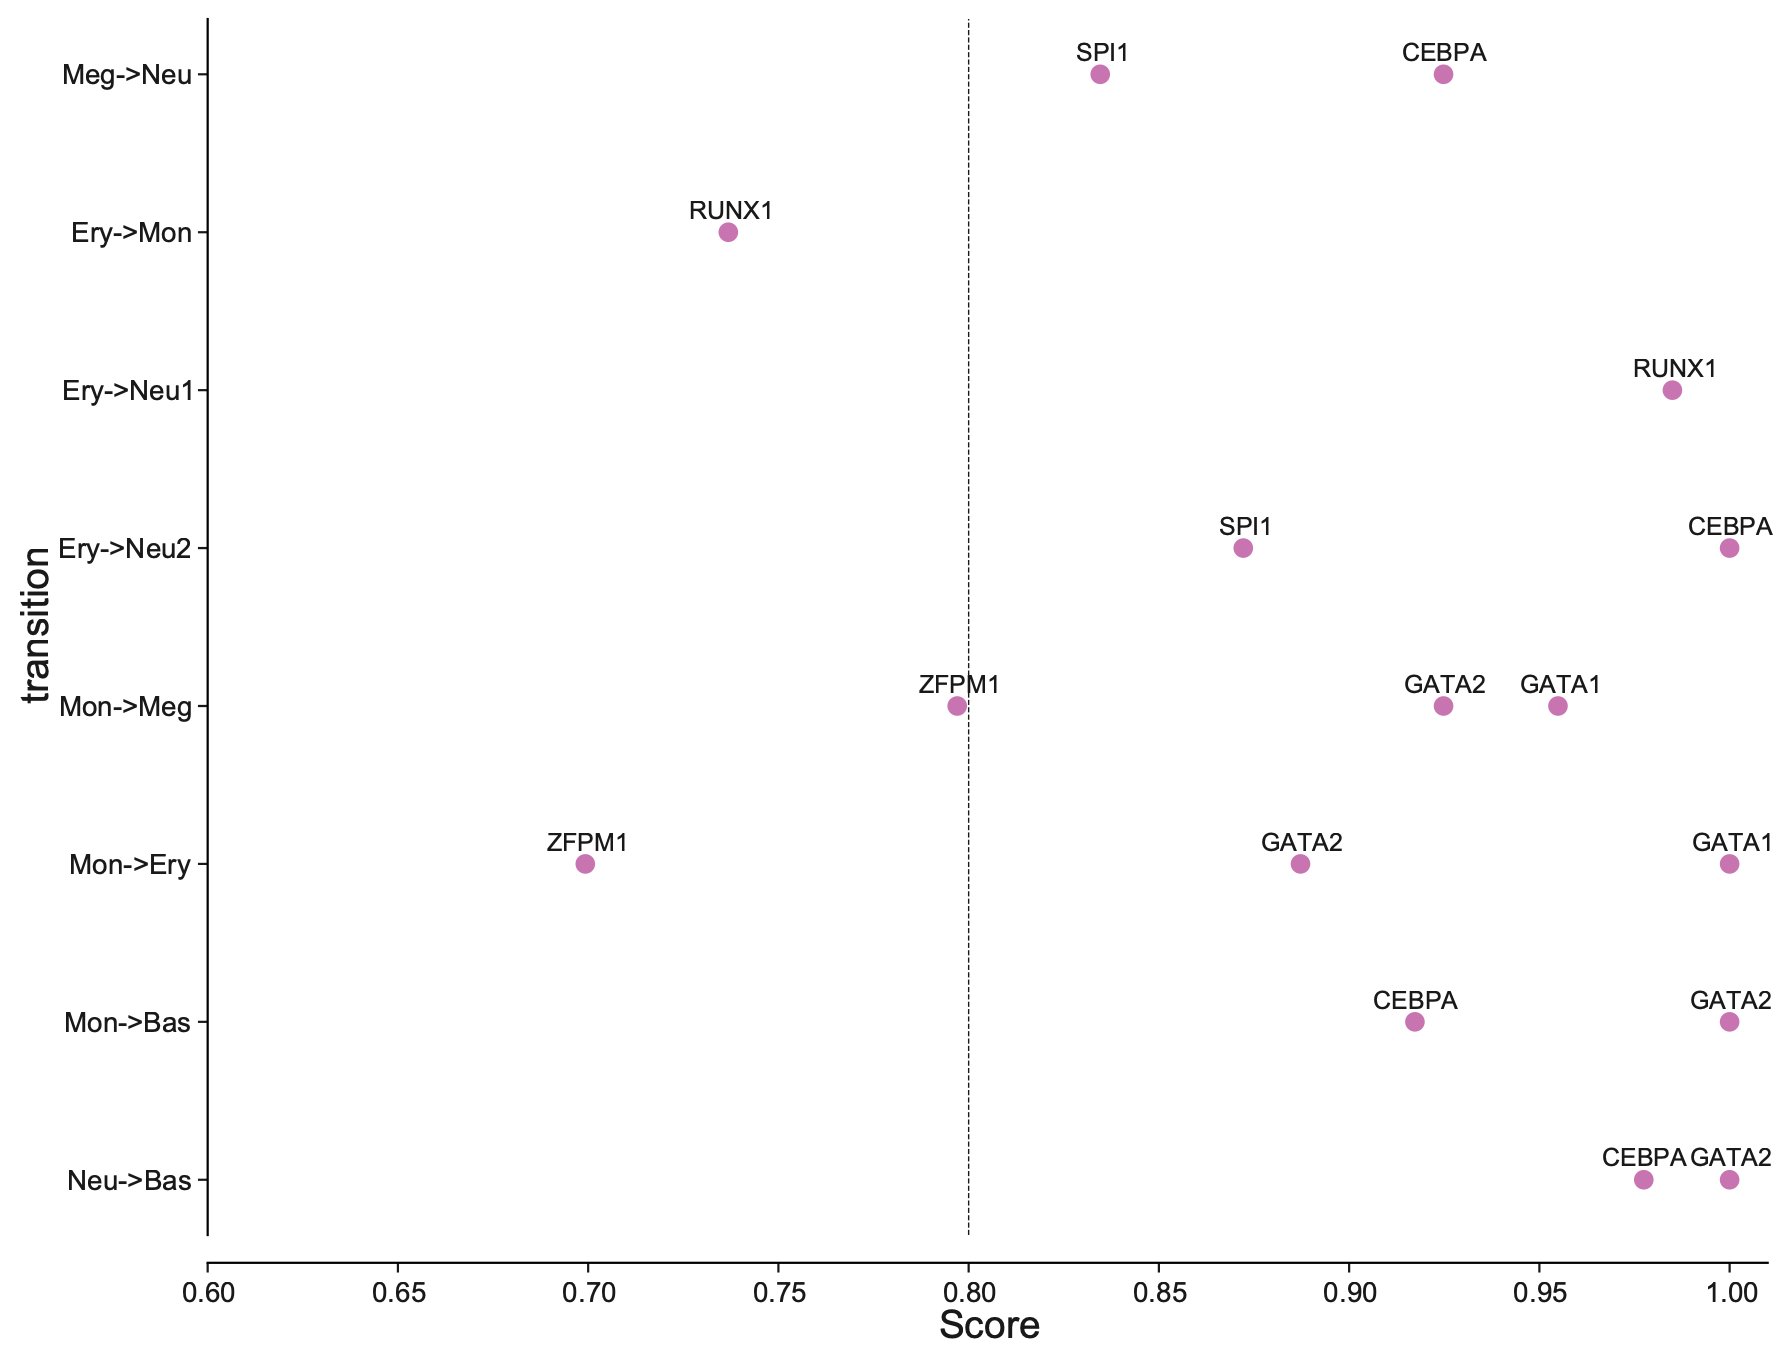

In [74]:
dyn.configuration.set_pub_style()
transition_color_dict = {"development": "#2E3192", "reprogramming": "#EC2227", "transdifferentiation": "#B9519E"}

reprogramming_mat_df_p_subset = reprogramming_mat_df_p.query("type == 'transdifferentiation'")
rank = reprogramming_mat_df_p_subset["rank"].values
transition = reprogramming_mat_df_p_subset["transition"].values
genes = reprogramming_mat_df_p_subset["genes"].values

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.scatterplot(
    y="transition",
    x="rank",
    data=reprogramming_mat_df_p_subset,
    ec=None,
    hue="type",
    alpha=0.8,
    ax=ax,
    s=50,
    palette=transition_color_dict,
    clip_on=False,
)

for i in range(reprogramming_mat_df_p_subset.shape[0]):
    annote_text = genes[i]  # STK_ID
    ax.annotate(
        annote_text, xy=(rank[i], transition[i]), xytext=(0, 3), textcoords="offset points", ha="center", va="bottom",
        fontsize=9
    )

plt.axvline(0.8, linestyle="--", lw=0.5)
ax.set_xlim(0.6, 1.01)
ax.set_xlabel("Score",  fontsize=14)
ax.set_ylabel("transition",  fontsize=14)
ax.set_yticklabels(list(reprogramming_mat_dict.keys())[6:], rotation=0)
ax.legend().set_visible(False)
ax.spines.top.set_position(("outward", 10))
ax.spines.bottom.set_position(("outward", 10))

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")


plt.tick_params(axis='both', which='both', labelsize=10)
plt.show()


## ROC Curve
Last but not least, lets evaluate our ranking via RoC curve. area=`0.83` indicates our ranking scores are reasonable.

In [75]:
all_ranks_list = [
    HSC_Meg_ranking,
    HSC_Ery_ranking,
    HSC_Bas_ranking,
    HSC_Mon_ranking,
    HSC_Neu_ranking,
    Meg_HSC_ranking,
    Ery_Mon_ranking,
    Ery_Neu_ranking,
    Mon_Bas_ranking,
    Neu_Bas_ranking,
    Mon_Meg_ranking,
    Mon_Ery_ranking,
    Meg_Neu_ranking,
    Ery_Neu_ranking,
]

all_ranks_df = pd.concat(all_ranks_list)

all_ranks_df["priority_score"] = (
    1 - np.tile(np.arange(HSC_Bas_ranking.shape[0]), len(all_ranks_list)) / HSC_Bas_ranking.shape[0]
)
# all_ranks_df['priority_score'].hist()
TFs = ranking["all"][ranking["TF"]].values
valid_TFs = np.unique(reprogramming_mat_df_p["genes"].values)


/var/folders/m5/dc_kmwcs2_3fqkytr_j09wx00000gn/T/ipykernel_22599/1617295339.py:35: UserWarning: Matplotlib is currently using cairo, which is a non-GUI backend, so cannot show the figure.
  plt.show()


<Figure size 130x100 with 0 Axes>

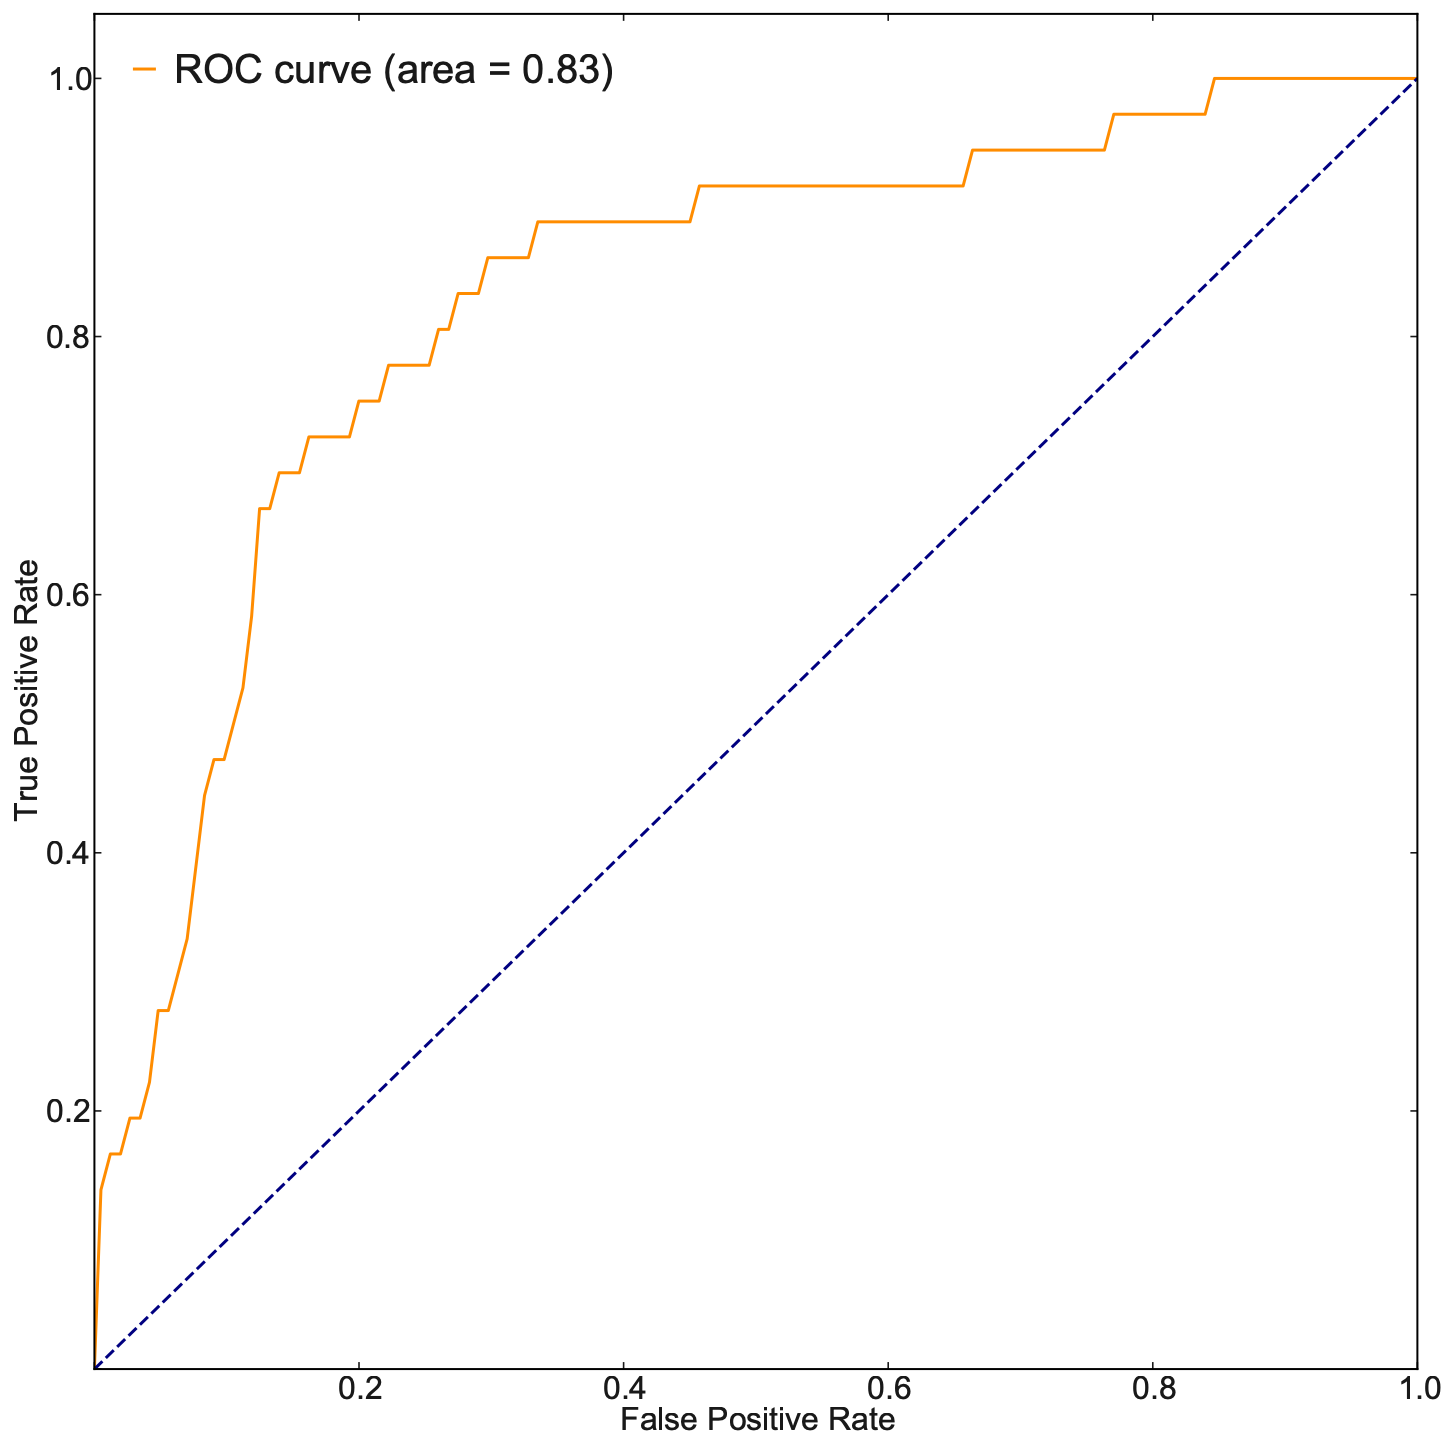

In [76]:
from sklearn.metrics import roc_curve, auc

use_abs = False
top_genes = len(TFs)

cls = all_ranks_df["known_TF"].astype(int)
pred = all_ranks_df["priority_score"]

fpr, tpr, _ = roc_curve(cls, pred)
roc_auc = auc(fpr, tpr)


dyn.configuration.set_pub_style_mpltex()
plt.figure(figsize=(1.3, 1))

lw = 1.5
fontsize=16
figure = plt.figure(figsize=(10, 10))

plt.tick_params(axis='both', which='both', labelsize=16)
plt.plot(fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=fontsize)
plt.ylabel("True Positive Rate", fontsize=fontsize)

# remove first x, y axis 0 tick
ax = plt.gca()
plt.setp(ax.get_yticklabels()[0], visible=False)    
plt.setp(ax.get_xticklabels()[0], visible=False)
# plt.title(cur_guide)
plt.legend(loc="lower right")
plt.legend(loc=2, prop={'size': 20})
plt.show()

plt.tight_layout()
